# EDA & Baseline: Previsão de Atrasos de Voos

**Objetivo:** Analisar visualmente os dados e testar um modelo mais simples possível de *baseline* para prever se um voo atrasará 5 minutos ou mais (`IS_DELAYED_5MIN`), dado que a previsão é feita 30 minutos antes da chegada agendada.

**Estapas da Análise:**
1.  **Análise da Variável Alvo:** Entender o desbalanceamento, padrões sazonais, diários e geográficos.
2.  **Análise de Features:** Investigar o poder preditivo das *features* de "tempo real" (ex: `DEPARTURE_DELAY`) e das *features* de "risco histórico" (ex: `ROUTE_ON_TIME_RATE`).
3.  **Modelo de Baseline:** Testar uma Regressão Logística simples usando *apenas* `DEPARTURE_DELAY` para ver o quão perto ela chega da "verdade".

## Configuração e Carregamento de Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from pathlib import Path

# Configurações do Seaborn para plots mais bonitos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# Ignorar avisos futuros do pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# CCarrega dados
PROJECT_ROOT = Path.cwd().parent
df = pd.read_parquet(PROJECT_ROOT/'data/df_limpo_com_features.parquet') 
df_sample = df.sample(1000000) # para análise visuais para evitar carregametno pesado das imagens.Também usado para treino rápido

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5714008 entries, 0 to 5714007
Data columns (total 57 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   YEAR                        int64         
 1   MONTH                       int64         
 2   DAY                         int64         
 3   DAY_OF_WEEK                 int64         
 4   FLIGHT_NUMBER               int64         
 5   TAIL_NUMBER                 object        
 6   ORIGIN_AIRPORT              object        
 7   DESTINATION_AIRPORT         object        
 8   SCHEDULED_DEPARTURE         object        
 9   DEPARTURE_TIME              object        
 10  DEPARTURE_DELAY             float64       
 11  TAXI_OUT                    float64       
 12  WHEELS_OFF                  float64       
 13  SCHEDULED_TIME              float64       
 14  ELAPSED_TIME                float64       
 15  AIR_TIME                    float64       
 16  DISTANCE          

# Parte 1: Análise da Variável Alvo (`IS_DELAYED_5MIN`)

Principais perguntas: quão dificil é o problema, onde, quando e com que frequência os atrasos ocorrem?

### 1.1 A Linha de Base: Quão difícil é o problema?

--- Análise de Desbalanceamento ---
Taxa de Atraso (>= 5 min): 29.36%


C:\Users\avpalves\AppData\Local\Temp\ipykernel_22448\3537458879.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Pontual (< 5min)', 'Atrasado (>= 5min)'])


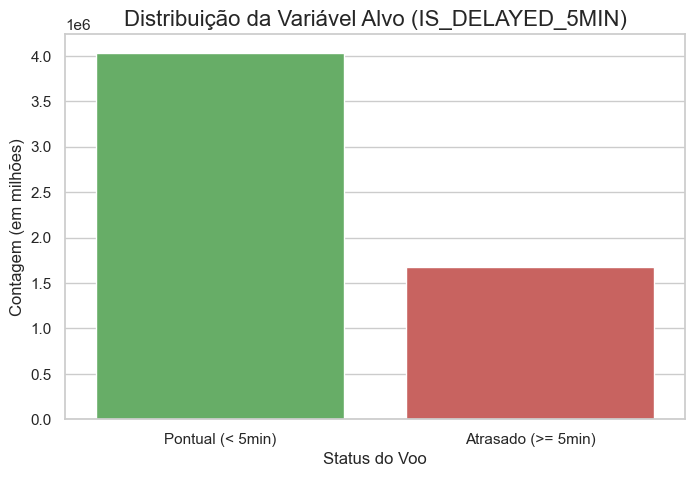

In [8]:
print("--- Análise de Desbalanceamento ---")

# Calcula a taxa de atraso
delay_rate = df['IS_DELAYED_5MIN'].mean()
print(f"Taxa de Atraso (>= 5 min): {delay_rate:.2%}")

# Plot
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='IS_DELAYED_5MIN', palette=['#5cb85c', '#d9534f'])
ax.set_xticklabels(['Pontual (< 5min)', 'Atrasado (>= 5min)'])
plt.title('Distribuição da Variável Alvo (IS_DELAYED_5MIN)', fontsize=16)
plt.xlabel('Status do Voo')
plt.ylabel('Contagem (em milhões)')
plt.show()

**Insight:** 

- Variável alvo desbalanceada, com *~30% dos voos atrasados*. Devemos ter cuidados para fazer uma divisão estratificada para treinamento dos dados. 
- Isso também defino o nosso modelo base: se para todos os voos, *chutássemos* "Pontual", acertariamos **70%** das vezes. Portanto, para justificar um modelo de Machine Learning, teremos que atingir acuracidade relevantemente acima de 70%. 

### 1.2 Padrões Temporais: *Quando* os atrasos ocorrem?

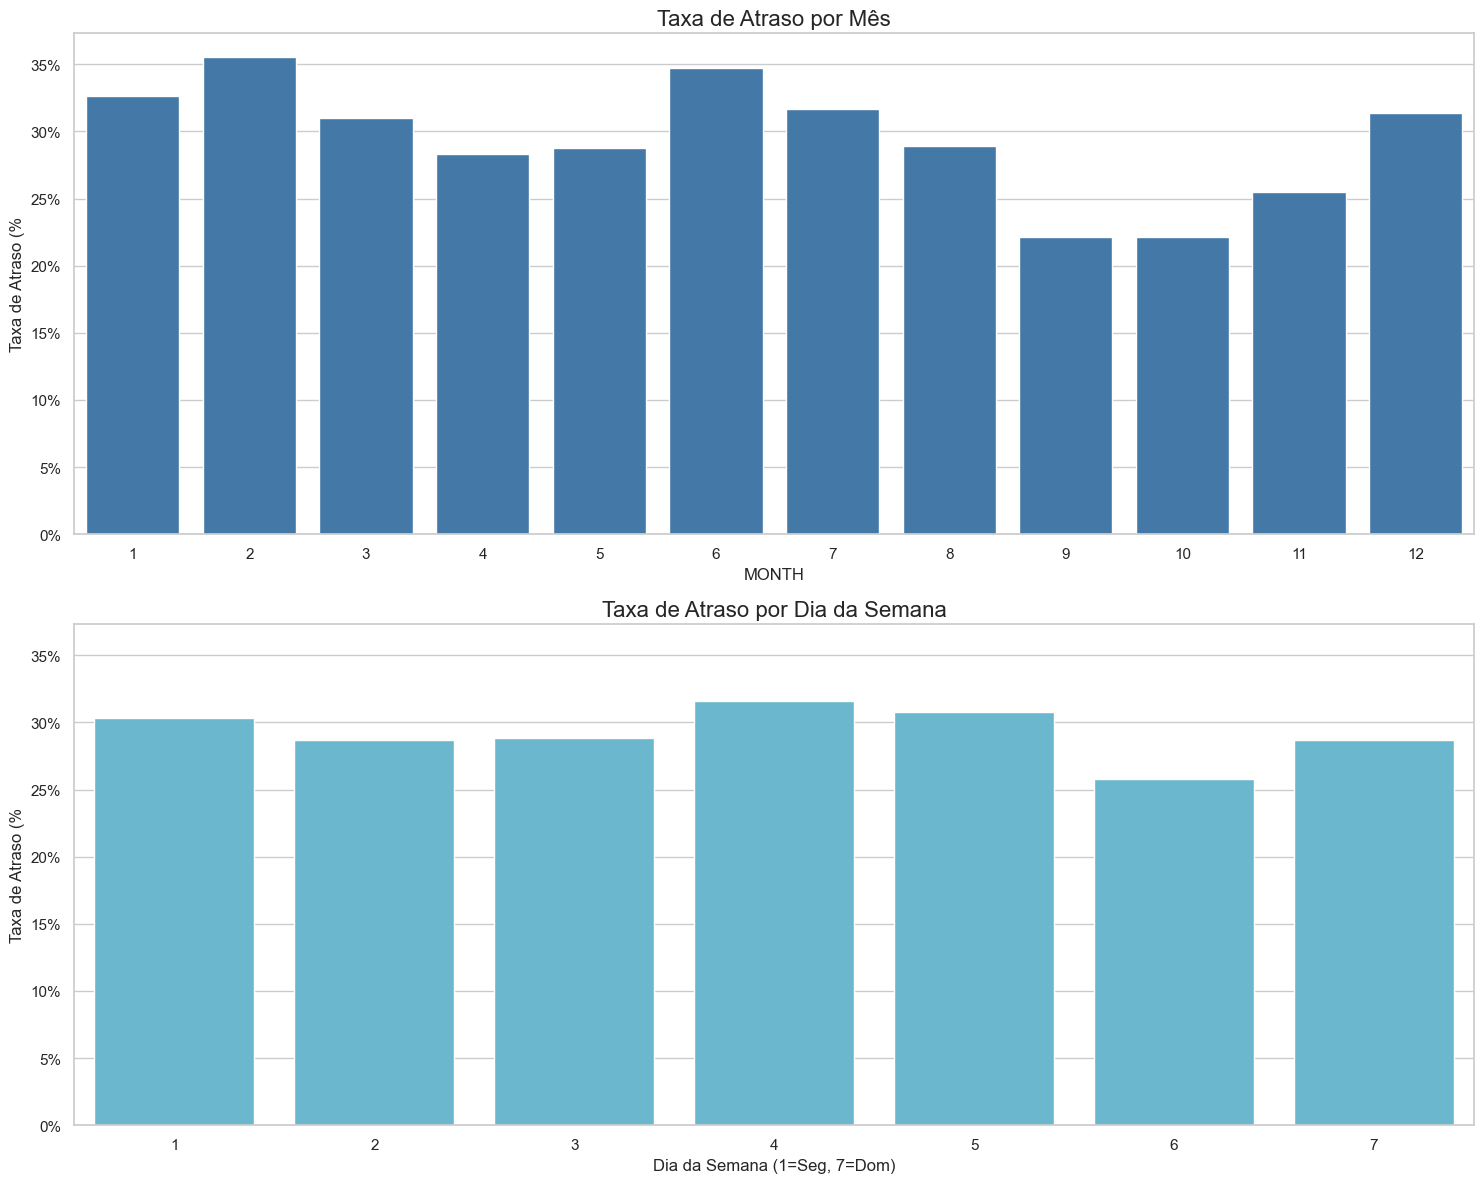

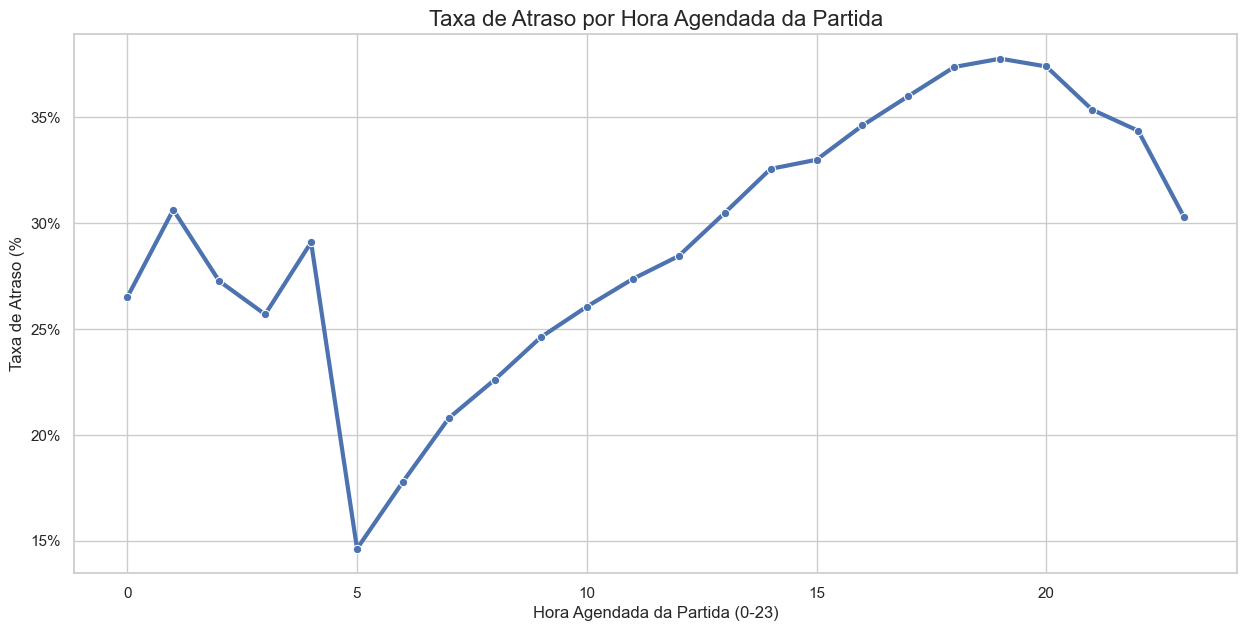

In [12]:
# Agrupa os dados por período de tempo e calcula a taxa de atraso
df_monthly = df.groupby('MONTH')['IS_DELAYED_5MIN'].mean().reset_index()
df_daily = df.groupby('DAY_OF_WEEK')['IS_DELAYED_5MIN'].mean().reset_index()
df_hourly = df.groupby('SCHEDULED_DEPARTURE_HOUR')['IS_DELAYED_5MIN'].mean().reset_index()

# Plot Sazonal (Mês)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharey=True)

sns.barplot(data=df_monthly, x='MONTH', y='IS_DELAYED_5MIN', ax=ax1, color='#337ab7')
ax1.set_title('Taxa de Atraso por Mês', fontsize=16)
ax1.set_ylabel('Taxa de Atraso (%')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}' ))

# Plot Semanal (Dia da Semana)
sns.barplot(data=df_daily, x='DAY_OF_WEEK', y='IS_DELAYED_5MIN', ax=ax2, color='#5bc0de')
ax2.set_title('Taxa de Atraso por Dia da Semana', fontsize=16)
ax2.set_xlabel('Dia da Semana (1=Seg, 7=Dom)')
ax2.set_ylabel('Taxa de Atraso (%')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}' ))

plt.tight_layout()
plt.show()

# Plot Diário (Hora da Partida)
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_hourly, x='SCHEDULED_DEPARTURE_HOUR', y='IS_DELAYED_5MIN', lw=3, marker = "o")
plt.title('Taxa de Atraso por Hora Agendada da Partida', fontsize=16)
plt.xlabel('Hora Agendada da Partida (0-23)')
plt.ylabel('Taxa de Atraso (%')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}' ))
plt.show()

**Insight :**
* Meses de alta temporada (Dez, Jan, Jun) tende a concerntrar mais atrasos.
* Não existe diferença alta (> 5%) entre os dias da semana, com excessão para sãbado que concentra a menor taxa de atrasos. 
* O gráfico de linha por hora mostra clara tedência nos atrasos a media que os dia inicia (6hrs) e apena volta a diminuir depois (19hrs), mantendo-se menor durante madrugada. Pode ser devido a um "efeito cascata": a taxa de atraso começa baixa pela e aumenta à medida que pequenos atrasos se acumulam. Durante o dia se tem o maior número de voos. 

### 1.3 Padrões Espaciais: *Onde* os atrasos ocorrem?

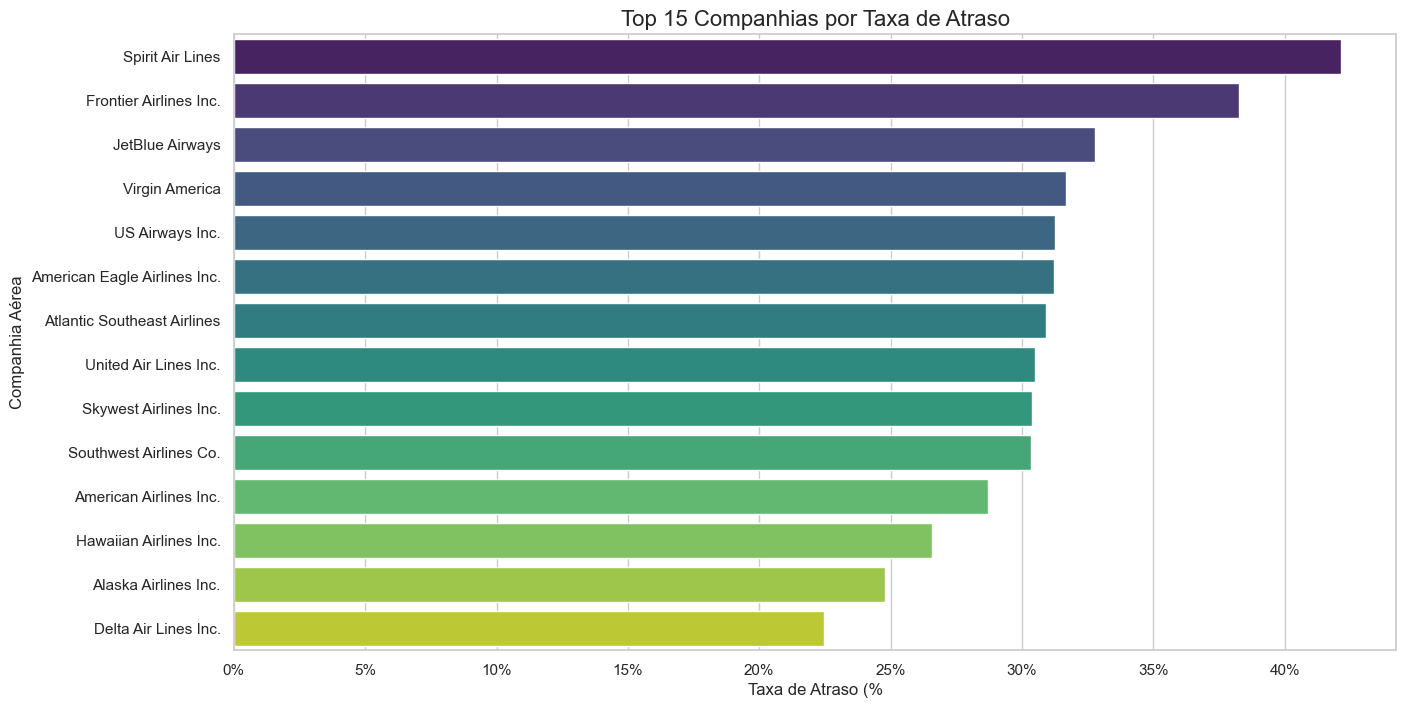

In [13]:
# Top 15 Piores Companhias por Taxa de Atraso
df_airline = df.groupby('AIRLINE_NAME')['IS_DELAYED_5MIN'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(data=df_airline.head(15), x='IS_DELAYED_5MIN', y='AIRLINE_NAME', palette='viridis')
plt.title('Top 15 Companhias por Taxa de Atraso', fontsize=16)
plt.xlabel('Taxa de Atraso (%')
plt.ylabel('Companhia Aérea')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}' ))
plt.show()

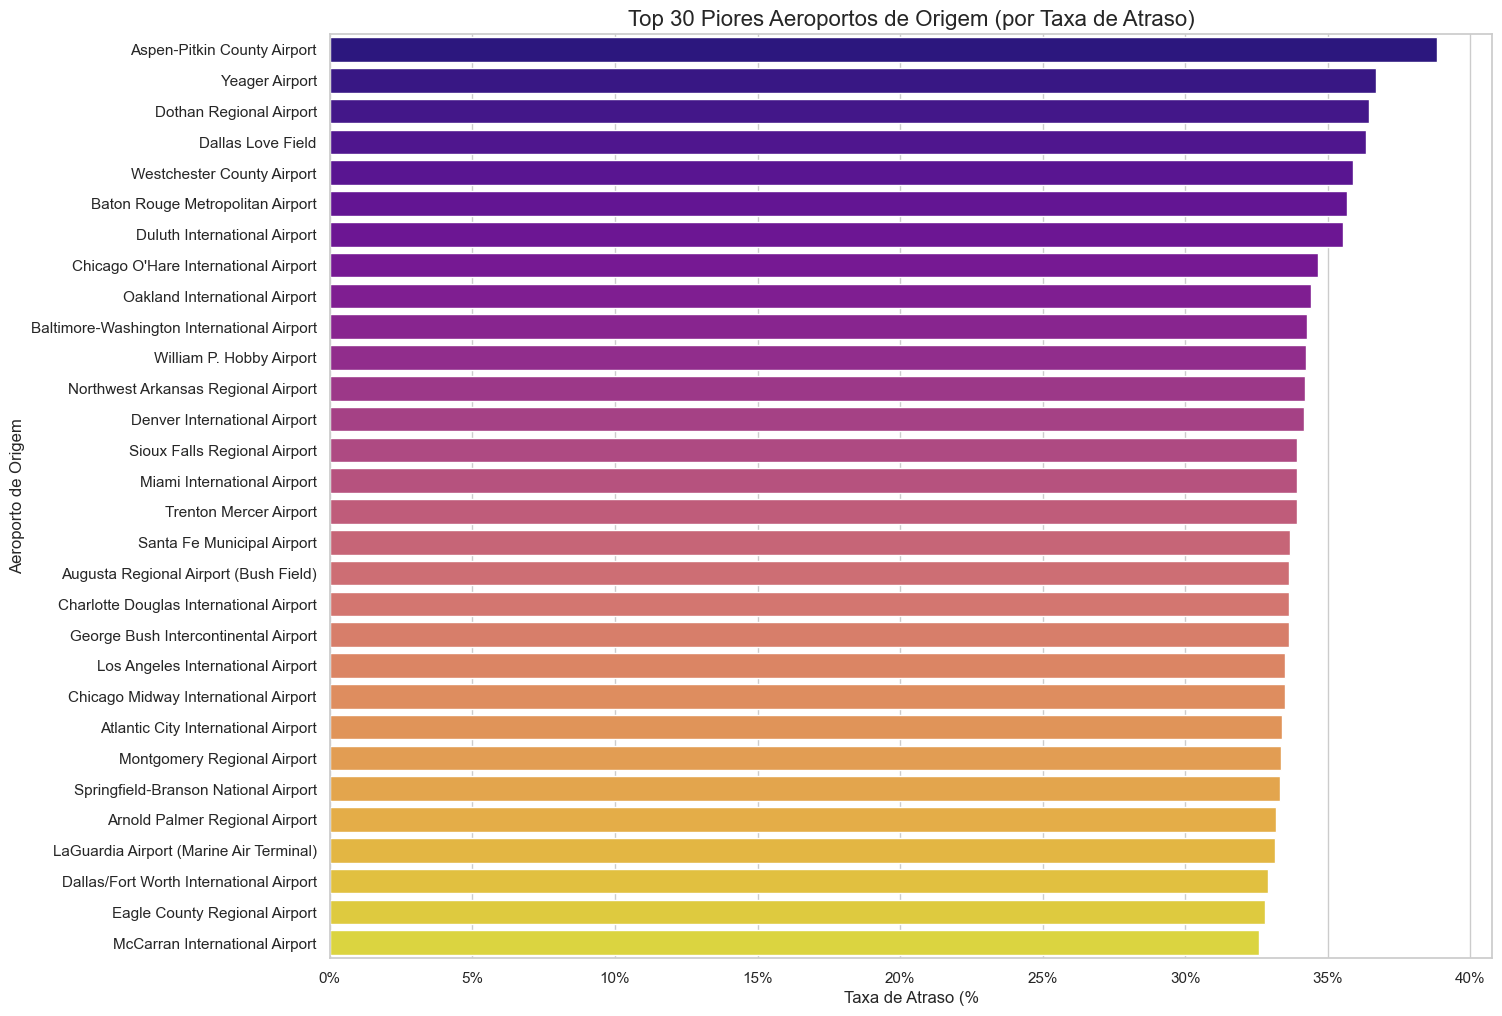

In [14]:
# Top 30 Piores Aeroportos de Origem (com tráfego relevante)

# 1. Contar voos por aeroporto
airport_counts = df['ORIGIN_AIRPORT_NAME'].value_counts()

# 2. Filtrar para aeroportos com tráfego mínimo (ex: 1000 voos no ano)
relevant_airports = airport_counts[airport_counts > 1000].index
df_relevant = df[df['ORIGIN_AIRPORT_NAME'].isin(relevant_airports)]

# 3. Calcular taxa de atraso e pegar os piores
df_airport = df_relevant.groupby('ORIGIN_AIRPORT_NAME')['IS_DELAYED_5MIN'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(15, 12))
sns.barplot(data=df_airport.head(30), x='IS_DELAYED_5MIN', y='ORIGIN_AIRPORT_NAME', palette='plasma')
plt.title('Top 30 Piores Aeroportos de Origem (por Taxa de Atraso)', fontsize=16)
plt.xlabel('Taxa de Atraso (%')
plt.ylabel('Aeroporto de Origem')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}' ))
plt.show()

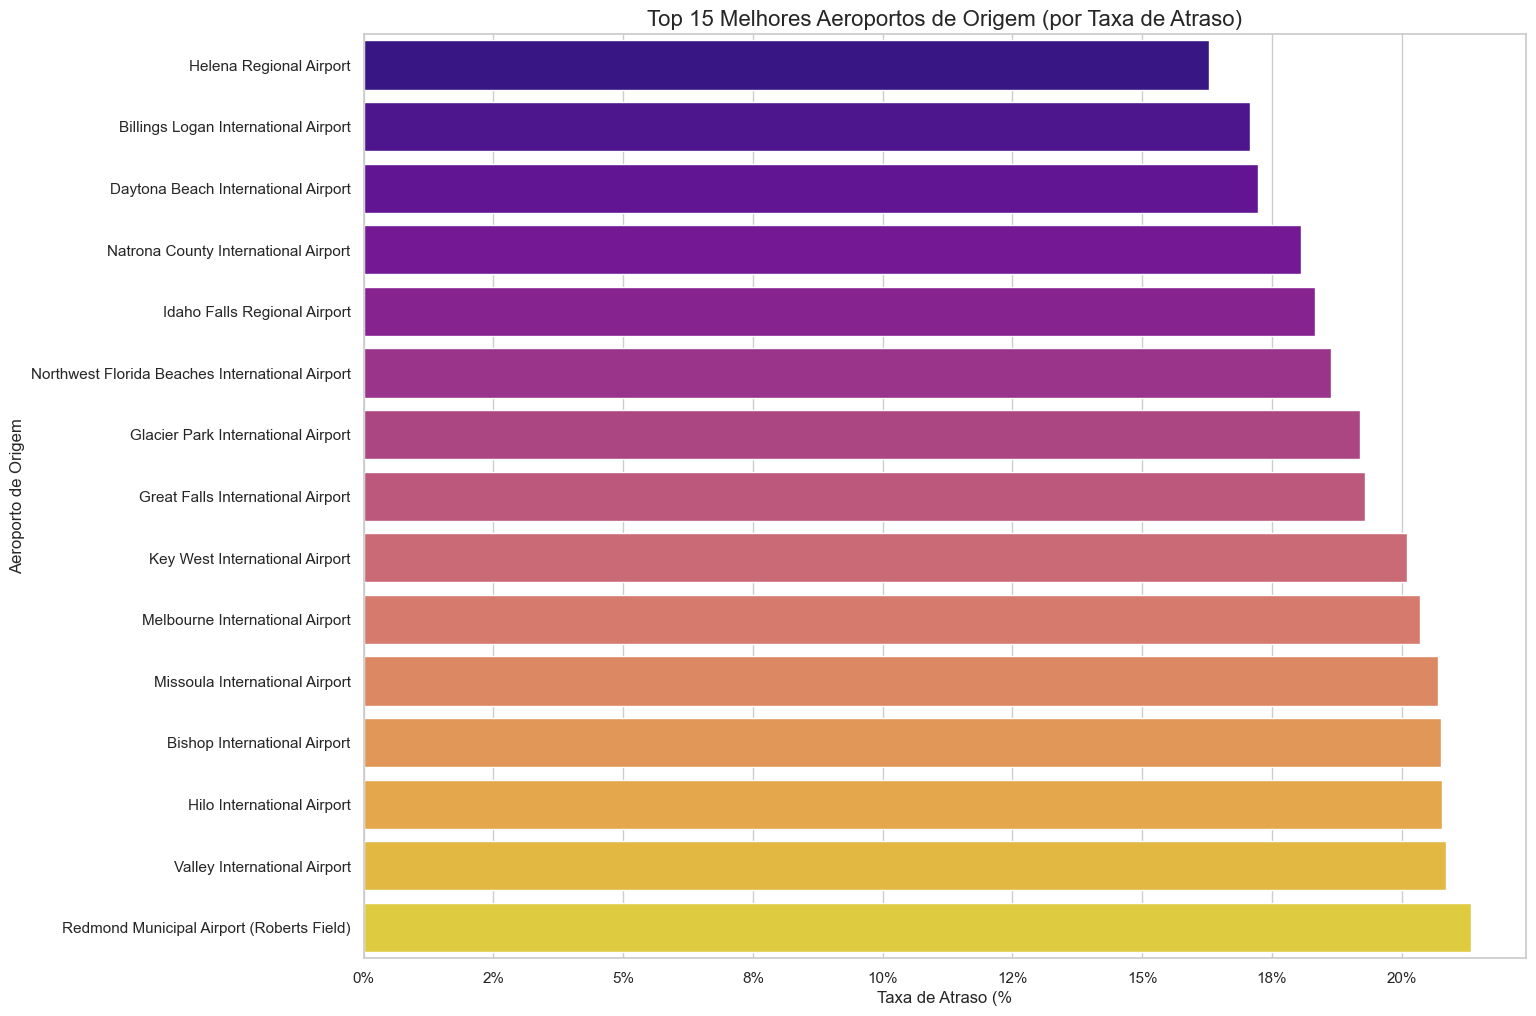

In [8]:
# Top 15 Melhores Aeroportos de Origem (com tráfego relevante)

# 1. Contar voos por aeroporto
airport_counts = df['ORIGIN_AIRPORT_NAME'].value_counts()

# 2. Filtrar para aeroportos com tráfego mínimo (ex: 1000 voos no ano)
relevant_airports = airport_counts[airport_counts > 1000].index
df_relevant = df[df['ORIGIN_AIRPORT_NAME'].isin(relevant_airports)]

# 3. Calcular taxa de atraso e pegar os piores
df_airport = df_relevant.groupby('ORIGIN_AIRPORT_NAME')['IS_DELAYED_5MIN'].mean().sort_values(ascending=True).reset_index()

plt.figure(figsize=(15, 12))
sns.barplot(data=df_airport.head(15), x='IS_DELAYED_5MIN', y='ORIGIN_AIRPORT_NAME', palette='plasma')
plt.title('Top 15 Melhores Aeroportos de Origem (por Taxa de Atraso)', fontsize=16)
plt.xlabel('Taxa de Atraso (%')
plt.ylabel('Aeroporto de Origem')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}' ))
plt.show()

**Insights**: 
* Existe claramente destinção com companhia que mais atrasam, sendo a primeira, *Spirit Airlines* com mais de **40%** de seus voos atrasados e *Delta Airlines* no ultimo luga no top 15 com aproximadamente **23%* de taxa de voos atrasados. **Se espera que a companhia seja uma forte preditora**
* O aeroporto de origem pode ser também uma forte preditora, com claro padrão, com taxas de atrasos variando de **~16,5%** (Helena Regional Airport)  a **~38%** (Aspen-Pitkin County Airport).


### 1.3.1 Mapa Geográfico de Tráfego

In [7]:

# 1. Agregar os dados da rota (não há memória para fazer gráfico sobre ~6 milhões de linhas).
# Precisamos das contagens de voos por rota, e das coordenadas

# Remove NaN de lat/lon antes de agrupar
df_geo = df.dropna(subset=['ORIGIN_LATITUDE', 'DEST_LATITUDE'])

# Remove latitude = 0
df_geo = df_geo.query("ORIGIN_LATITUDE != 0 | DEST_LATITUDE != 0")

# Agrupa para obter contagem de voos e coordenadas únicas
df_routes_agg = df_geo.groupby(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']).agg(
    FLIGHT_COUNT=('YEAR', 'count'),
    ORIGIN_LAT= ('ORIGIN_LATITUDE', 'first'),
    ORIGIN_LON= ('ORIGIN_LONGITUDE', 'first'),
    DEST_LAT=   ('DEST_LATITUDE', 'first'),
    DEST_LON=   ('DEST_LONGITUDE', 'first'),
    AVG_DELAY_RATE= ('IS_DELAYED_5MIN', 'mean')
).reset_index()

# 2. Filtrar para as top N rotas (ex: top 500 rotas mais voadas) - limitação de memória
top_routes = df_routes_agg.nlargest(5000, 'FLIGHT_COUNT')

# 3. Criar o mapa com Plotly
fig = go.Figure()

# Adiciona os aeroportos (pontos)
fig.add_trace(go.Scattergeo(
    locationmode='USA-states',
    lon=pd.concat([top_routes['ORIGIN_LON'], top_routes['DEST_LON']]),
    lat=pd.concat([top_routes['ORIGIN_LAT'], top_routes['DEST_LAT']]),
    mode='markers',
    marker=dict(
        color='black',
        size=3,
        opacity=0.5
    ),
    name='Aeroportos'
))

# Adiciona as linhas (rotas)
for i, row in top_routes.iterrows():
    fig.add_trace(go.Scattergeo(
        locationmode='USA-states',
        lon=[row['ORIGIN_LON'], row['DEST_LON']],
        lat=[row['ORIGIN_LAT'], row['DEST_LAT']],
        mode='lines',
        line=dict(width=0.5, color='#337ab7'),
        opacity=max(0.2, (row['FLIGHT_COUNT'] / top_routes['FLIGHT_COUNT'].max())),
        hoverinfo='skip'#,
        # name=f"{row['ORIGIN_AIRPORT']} > {row['DESTINATION_AIRPORT']}"
    ))

fig.update_layout(
    title_text='Top 5000 Rotas de Voo nos EUA (Espessura = Frequência)',
    showlegend=False,
    geo=dict(
        scope='usa',
        projection_type='albers usa',
        showland=True,
        landcolor='rgb(243, 243, 243)',
        subunitcolor='rgb(204, 204, 204)',
    ),
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()

**Insights**:
* A grande maioria dos voos se concentram em alguns poucos aerportos espalhados no país. 
* A região de maior tráfego, parece ser a região de NY de DC, seguindo por Seatle. 

### 1.4 *Por que* os atrasos ocorrem?

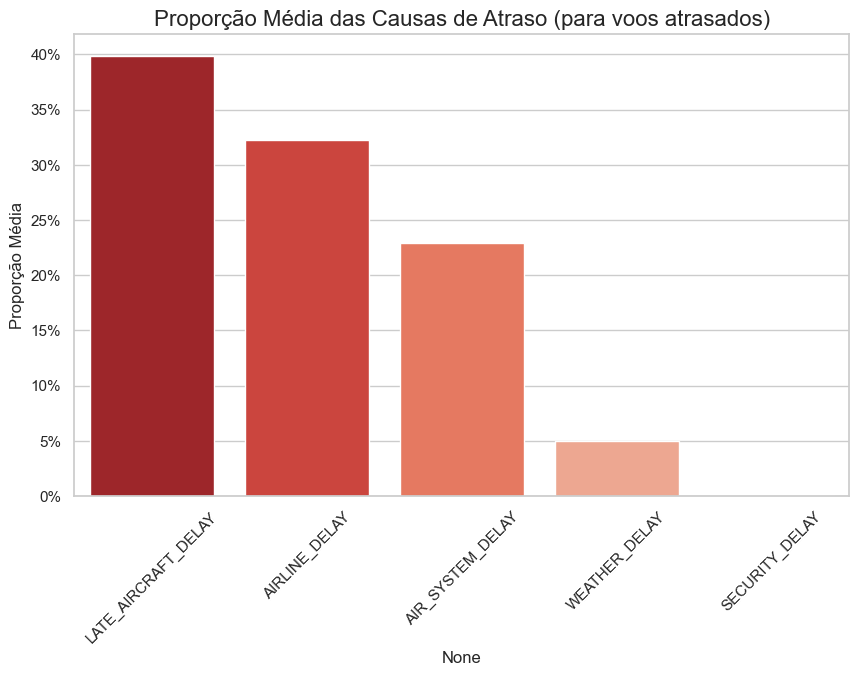

In [9]:

# Pega apenas voos atrasados
df_delayed = df[df['IS_DELAYED_5MIN'] == 1]

delay_cols = ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

# Calcula a média de cada tipo de atraso
delay_means = df_delayed[delay_cols].mean()
delay_means = delay_means / delay_means.sum() # Converte para proporção
delay_means = delay_means.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=delay_means.index, y=delay_means.values, palette='Reds_r')
plt.title('Proporção Média das Causas de Atraso (para voos atrasados)', fontsize=16)
plt.ylabel('Proporção Média')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}' ))
plt.xticks(rotation=45)
plt.show()


**Insights:**
* `LATE_AIRCRAFT_DELAY` e `AIRLINE_DELAY` são causas dominantes. Isso reforça a ideia de que `DEPARTURE_DELAY` será a *feature* mais preditiva. 
* `LATE_AIRCRAFT_DELAY` reforça o efeito cascata, visto no gráfico de linha representando taxa de atraso por hora do dia. Se um voo atrasa, o próximo voo daquela mesma aeronave é possível que irá se atrasar também. 
* `AIR_SYSTEM_DELAY` está relacionado a controle de tráfego e aparece como váriavel significativa nos atrasos. **IMPORTANTE**: *talvez não seja possível usar essa variável, porque possívelmente é a soma do atraso tanto na decolagem quanto no pouso. Nesse último caso não teremos a variável disponível no momento da predição.*
* `WEATHER_DELAY` e `SECURITY_DELAY` são as causas menos significativas de atraso. **Isso mostra que o problema de atraso nos voos é sistêmico e PREVISÍVEL**.

# Parte 2: Análise das Variáveis Explicatórias (Features)

Quão bem as *variaveis alvo* se separam entre as classes "Pontual" e "Atrasado"?

### 2.1 Feature de "Tempo Real": `DEPARTURE_DELAY`

**A partir de agora utilizamos uma amostra com 1 Milhão de linhas da tabela**.

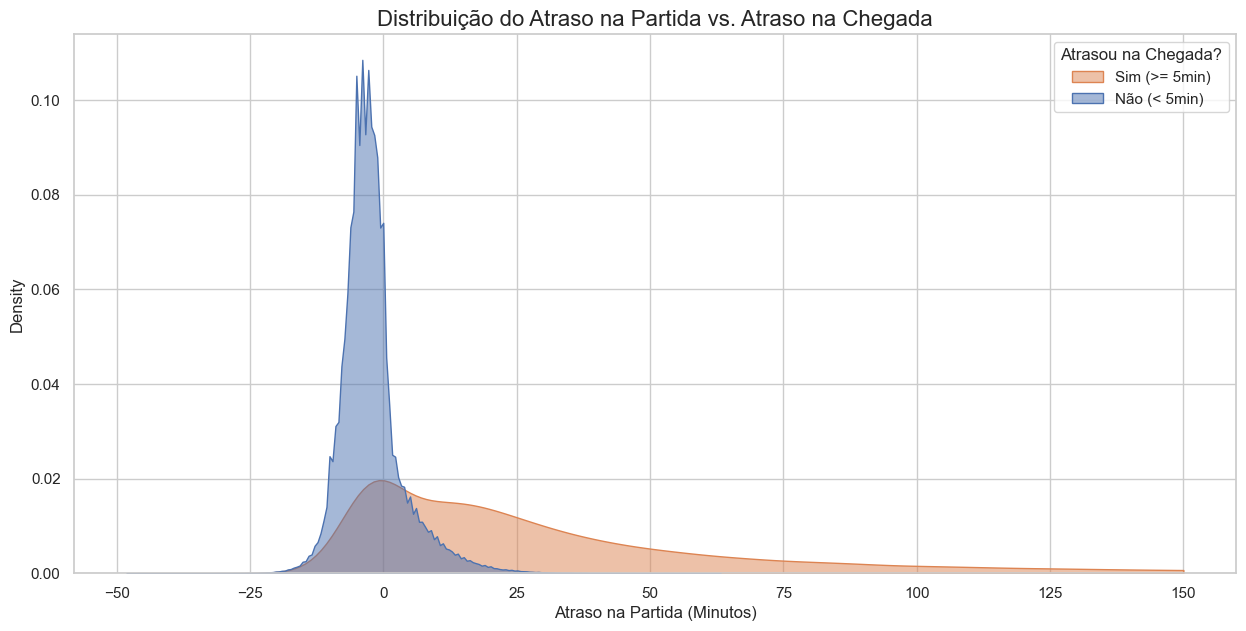

In [10]:
    
plt.figure(figsize=(15, 7))
# Usamos clip para cortar os valores extremos e ver melhor o centro da distribuição
sns.kdeplot(data=df_sample, x='DEPARTURE_DELAY', hue='IS_DELAYED_5MIN', 
            common_norm=False, clip=(-50, 150), fill=True, alpha=0.5)
plt.title('Distribuição do Atraso na Partida vs. Atraso na Chegada', fontsize=16)
plt.xlabel('Atraso na Partida (Minutos)')
plt.legend(title='Atrasou na Chegada?', labels=['Sim (>= 5min)', 'Não (< 5min)'])
plt.show()

**Insight:** Esse gráfico mostra a distribuição de atrasos (minutos) na partida que resultaram em atraso (> 5min) na chegada. 
* Esperava ver uma separação maior entre o que o que atrasou na saída e chegou atrasado na chegada. Contudo observação uma área considerável de sobreposição. *Isso indica que uma parcela dos voos que sairam no horário, chegou atraso no destino*. * Apesar da sobreposição, *há uma clara indicação que a probabilidade de um voo se atrasar na chegada é consideralvemente maior se ele se atrasou na saída.* Essa indicação é reforçada principalmente para a longa calda à direita para voos que se atrasaram na chegada.
* Existe uma pequena parcela de voos que *apesar de atrasado na saída, conseguiu reverter o atraso durante o voo e, chegar no horário*.
* Uma parcela dos voos que se atrasaram na chegada, sairam no horário ou adiantado, *reforçando a hipotese de que nem todo atraso na chegada é resultado de atraso na saída*. 
* Por fim, a variável `DEPARTURE_DELAY` ainda aparenta ser significativa, mas não tanto quanto se esperava. *Isso é um indicativo que talvez valha a pena um modelo complexo de previsão de atrasos*. 

### 2.2 Feature de "Risco Histórico": `ROUTE_ON_TIME_RATE`

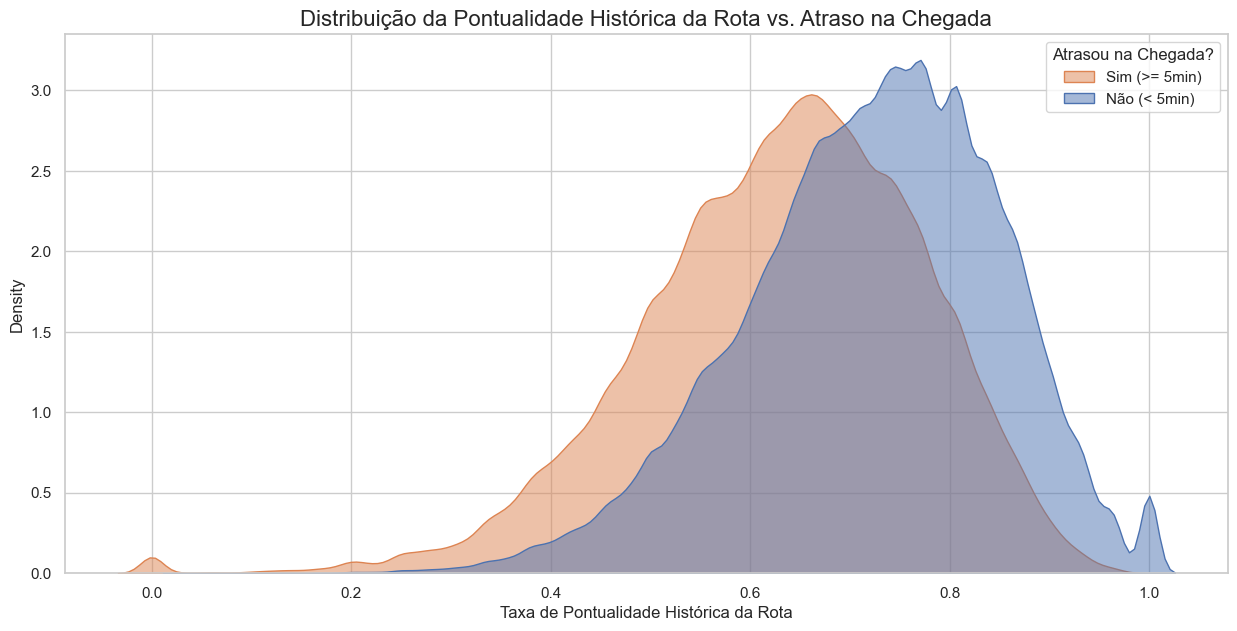

In [11]:
plt.figure(figsize=(15, 7))
sns.kdeplot(data=df_sample, x='ROUTE_ON_TIME_RATE', hue='IS_DELAYED_5MIN', 
            common_norm=False, fill=True, alpha=0.5)
plt.title('Distribuição da Pontualidade Histórica da Rota vs. Atraso na Chegada', fontsize=16)
plt.xlabel('Taxa de Pontualidade Histórica da Rota')
plt.legend(title='Atrasou na Chegada?', labels=['Sim (>= 5min)', 'Não (< 5min)'])
plt.show()

**Insight:**
* O oposto do gráfico anterior: a curva "Pontual" (Azul) deve estar à direita (alto `ROUTE_ON_TIME_RATE`), e a "Atrasado" (Laranja) à esquerda. Apesar de grande area de sobreposição, vemos claramente picos distintos para as duas distribuição. Isso valida a engenharia de features.

### 2.3 Features de "Contexto" e Correlação

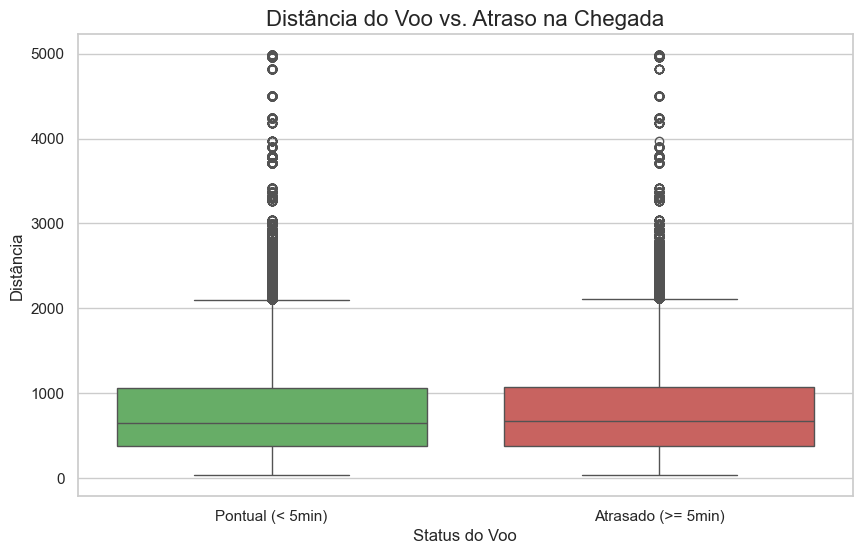

In [17]:
# Boxplot: Distância vs. Atraso
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_sample,
    x='IS_DELAYED_5MIN',
    y='DISTANCE',
    palette=['#5cb85c', '#d9534f']
)
plt.title('Distância do Voo vs. Atraso na Chegada', fontsize=16)
plt.xlabel('Status do Voo')
plt.ylabel('Distância')

plt.xticks([0, 1], ['Pontual (< 5min)', 'Atrasado (>= 5min)'])

plt.show()


**Insignts**:
* Não existe diferença nas distâncias entre *Pontual* e *Atrasado*. O que indica que essa feature é uma *fraca preditora.*
* Isso reforça a ideia de que a maioria dos atrasos não estão ligados a eventos ocorridos durante o voos (caso fosse, maior distância implicaria em maiores atrasos). Reforçando a ideia de que **os atrasos são sistêmicos e previsiveis**.  

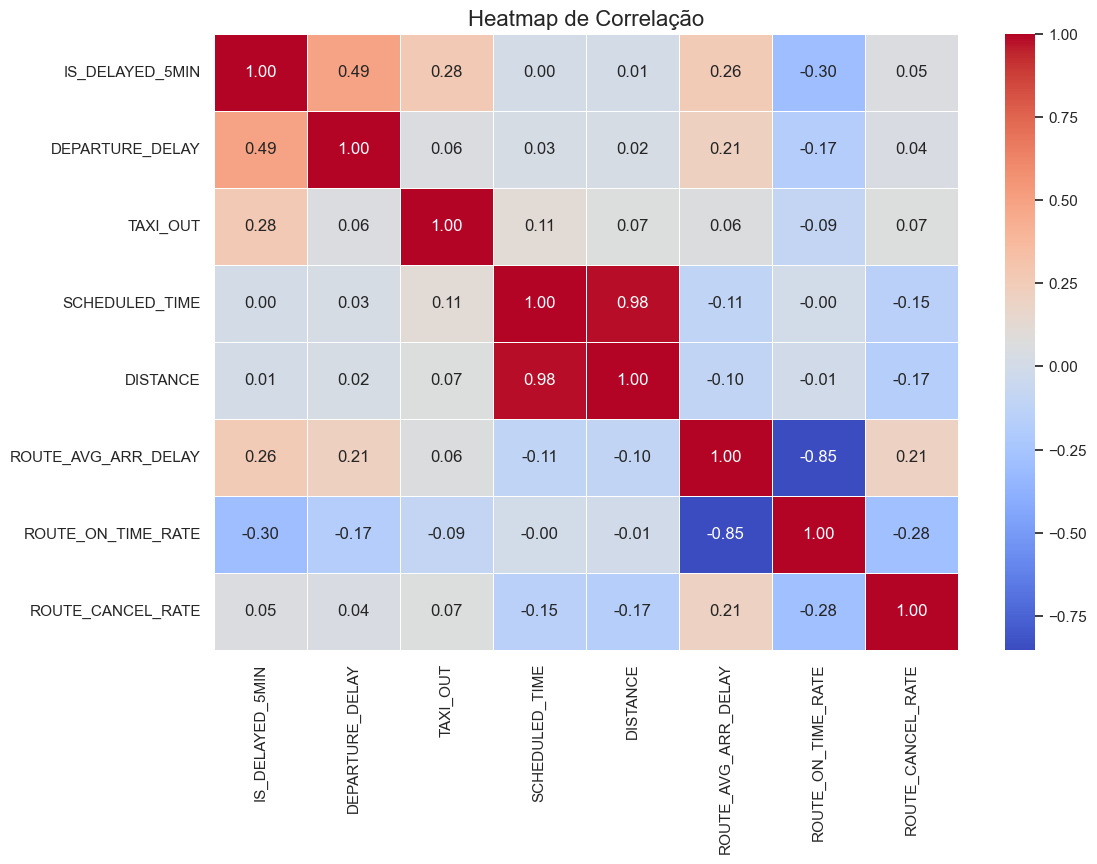

In [18]:
# Heatmap de Correlação (apenas features numéricas relevantes)
features_num = [
    'IS_DELAYED_5MIN',
    'DEPARTURE_DELAY',
    'TAXI_OUT',
    'SCHEDULED_TIME',
    'DISTANCE',
    'ROUTE_AVG_ARR_DELAY',
    'ROUTE_ON_TIME_RATE',
    'ROUTE_CANCEL_RATE'
]

corr = df[features_num].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap de Correlação', fontsize=16)
plt.show()

**Insight Esperado:**
* Há forte correlação (0.49) entre a variável alvo e `DEPARTURE_DELAY`.
* O tempo de taxiamento no voo (`TAXI_OUT`) de partida é o segundo maior preditor (entre as variaveis númericas), indicando que quanto mais tempo leva para o taxiamento, maior é a probabilidade de atraso. Porssivelmente correlacionado à alto tráfego.
* O taximento na partida `TAXI_OUT`, não se correlaciona com `DEPARTURE_DELAY`, mostrando ser dois evento independentes. Portanto esperamos que essas duas feature (`DEPARTURE_DELAY`) e (`TAXI_OUT`) seja as duas mais relevantes do modelo. 
* `ROUTE_AVG_ARR_DELAY` e `ROUTE_ON_TIME_RATE` tem correlação moderada (0.26 e -0.30 respectivamente) com atraso na chegada, *confirmando o problema operacional sistêmico* e portanto confirmando a engenharia de features.
* No geral existe *multicolinearidade*, com excessão para as variáveis `DISTANCE` e `SCHEDULED_TIME`  com correlação de 0.98, o que é esperado (voos mais longos são mais tardes, mais curtos são mais cedos).

# Parte 3: Modelo de Baseline (Regressão Logística Simples)

Hipótese: nem todo atraso é motivado pelo *DEPARTURE_DELAY* mas todo departure_delay quase que invariavelmente gerará um atraso.

Caso uma quantidade significativa de atrasos é quase que inteiramente justificada pelo *DEPARTURE_DELAY* um sistema de ML não para sentido para o projeto pois, poderemos facilmente estimar o atraso na chegada, com apenas o atraso na saída. 

Usaremos um modelo de Regressão Logística treinado **apenas com `DEPARTURE_DELAY`** para prever `IS_DELAYED_5MIN` e testar a hipótese: 

    * DEPARTURE_DELAY é *feature* suficientemente forte para, com confiança aceitavel, prever o atraso em voos.

In [3]:
print("--- Preparando dados para Modelo de Baseline ---")

# O dataset é muito grande, treinar em 5.7M de linhas levará tempo.
# Vamos usar uma amostra estratificada de 1M de linhas para um teste rápido.
df_model_sample = df_sample.copy()

# 1. Definir X e y
# Muito embora a tabela já foi limpa, apenas para garantir que não dados ausentes.
df_model_sample = df_model_sample.dropna(subset=['DEPARTURE_DELAY', 'IS_DELAYED_5MIN'])

X = df_model_sample[['DEPARTURE_DELAY']]
y = df_model_sample['IS_DELAYED_5MIN']

# 2. Normalizar os dados (bom para Regressão Logística)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Dividir em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y)

print(f"Tamanho do Treino: {len(y_train)} | Tamanho do Teste: {len(y_test)}")
print(f"Taxa de Atraso no Treino: {y_train.mean():.2%}")
print(f"Taxa de Atraso no Teste: {y_test.mean():.2%}")

--- Preparando dados para Modelo de Baseline ---
Tamanho do Treino: 700000 | Tamanho do Teste: 300000
Taxa de Atraso no Treino: 29.38%
Taxa de Atraso no Teste: 29.38%


In [4]:
print("--- Treinando Modelo de Baseline (Regressão Logística) ---")

# INSTRUÇÃO IMPORTANTE: obtida do CHATgpt
# solver='saga' é bom para datasets grandes, 'liblinear' é bom para simples.
# class_weight='balanced' ajuda com o desbalanceamento identificado na primeira parte.
model = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')
model.fit(X_train, y_train)

print("Modelo treinado com sucesso.")


--- Treinando Modelo de Baseline (Regressão Logística) ---
Modelo treinado com sucesso.


### 3.1 Avaliação do Modelo Simples

--- Relatório de Classificação (Modelo de 1 Feature) ---
                    precision    recall  f1-score   support

  Pontual (< 5min)       0.89      0.91      0.90    211854
Atrasado (>= 5min)       0.77      0.72      0.74     88146

          accuracy                           0.85    300000
         macro avg       0.83      0.81      0.82    300000
      weighted avg       0.85      0.85      0.85    300000

--- Matriz de Confusão ---


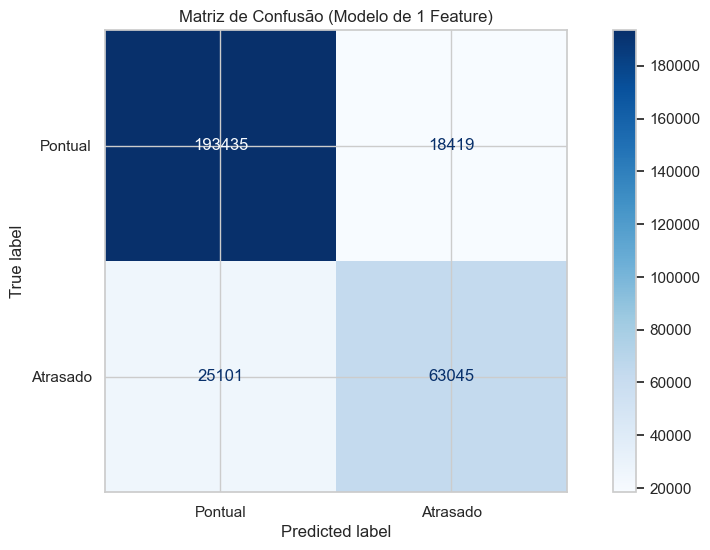


AUC-ROC Score: 0.8705


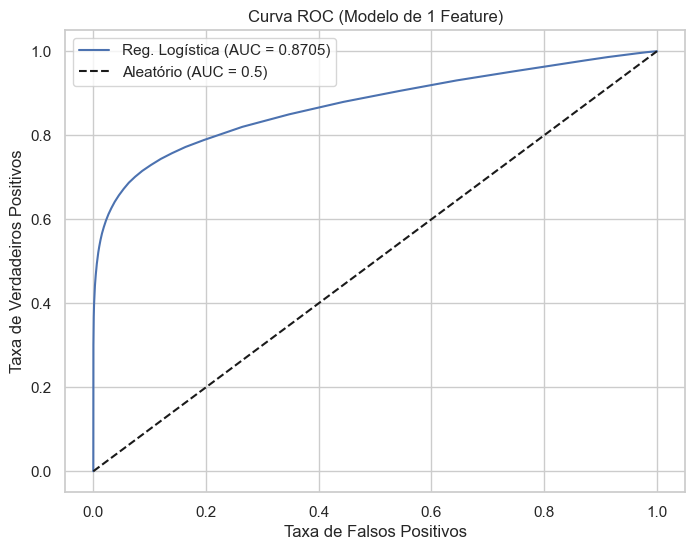

In [5]:
# 1. Fazer previsões
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 2. Relatório de Classificação
print("--- Relatório de Classificação (Modelo de 1 Feature) ---")
print(classification_report(y_test, y_pred, target_names=['Pontual (< 5min)', 'Atrasado (>= 5min)'] ))

# 3. Matriz de Confusão
print("--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Pontual', 'Atrasado']).plot(cmap='Blues')
plt.title('Matriz de Confusão (Modelo de 1 Feature)')
plt.show()

# 4. Curva ROC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Reg. Logística (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5)')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC (Modelo de 1 Feature)')
plt.legend()
plt.show()

**Análise da Hipótese:**

O `classification_report` é a chave aqui. 
* **Acurácia (`accuracy`)**: Provavelmente será alta (ex: 85-90%).
* **Recall (Classe "Atrasado")**: Esta é a métrica mais importante para o seu *use case* (Gestão de Conexões). Ela responde: "De todos os voos que *realmente* atrasaram, quantos o nosso modelo pegou?" Um `recall` de 90% aqui seria excelente.
* **Precisão (Classe "Atrasado")**: Responde: "De todos os voos que o modelo *disse* que iam atrasar, quantos realmente atrasaram?"

**Veredito:** Se o `recall` e o `AUC` deste modelo simples já forem > 0.90, sua hipótese está correta. O `DEPARTURE_DELAY` é tão dominante que um modelo mais complexo pode trazer apenas ganhos marginais (ex: prever os casos onde `DEPARTURE_DELAY` é 0, mas o voo atrasa mesmo assim).

### 3.2 Visualizando a Probabilidade (A Curva Sigmóide)

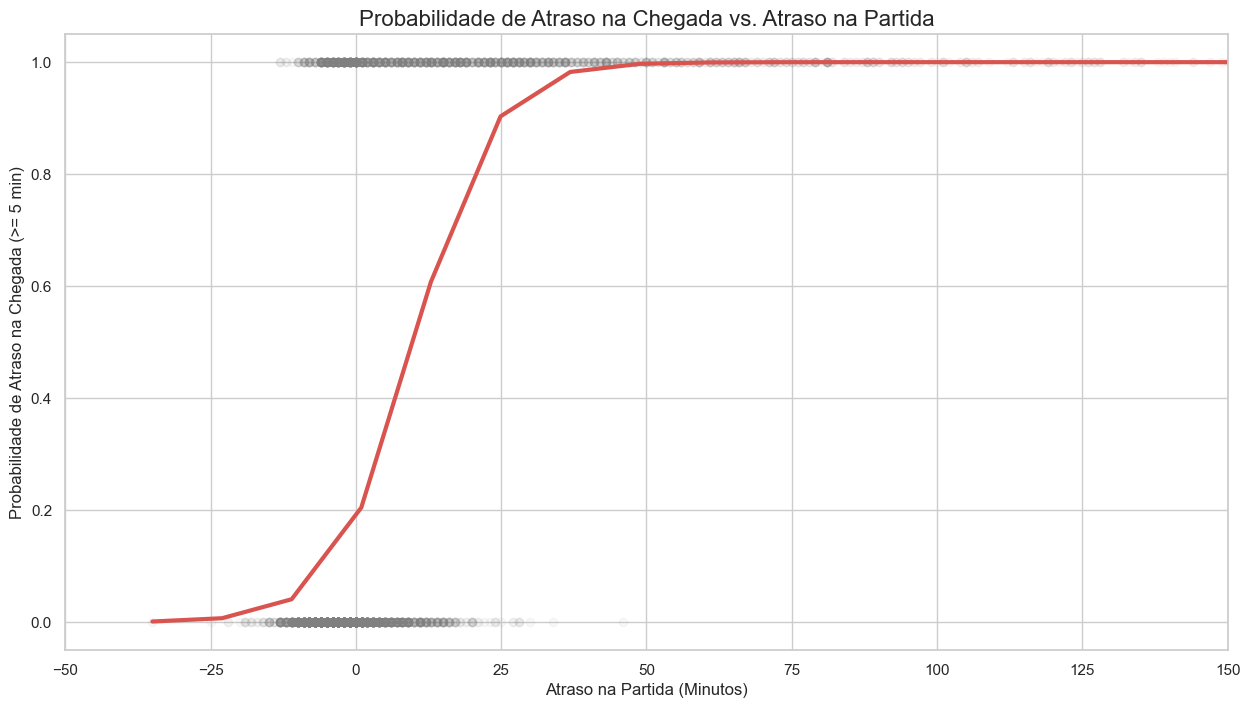

In [6]:
# Para plotar a curva sigmóide, precisamos dos dados NÃO normalizados no eixo X
X_unscaled = scaler.inverse_transform(X_test)

# Criar um dataframe temporário para o regplot
df_plot = pd.DataFrame({
    'DEPARTURE_DELAY': X_unscaled.flatten(),
    'IS_DELAYED_5MIN': y_test,
    'PROBABILITY': y_pred_proba
})

# Plotar a curva de regressão logística
plt.figure(figsize=(15, 8))

sns.regplot(
    data=df_plot.sample(min(5000, len(df_plot))),
    x='DEPARTURE_DELAY',
    y='IS_DELAYED_5MIN',
    logistic=True,
    ci=None,
    scatter_kws={'alpha': 0.05, 'color': 'gray'},
    line_kws={'color': '#d9534f', 'lw': 3}  # ✅ correct way to set line color and width
)

plt.title('Probabilidade de Atraso na Chegada vs. Atraso na Partida', fontsize=16)
plt.xlabel('Atraso na Partida (Minutos)')
plt.ylabel('Probabilidade de Atraso na Chegada (>= 5 min)')
plt.xlim(-50, 150)
plt.show()


**Análise Final da Hipótese:**

Este gráfico é a prova visual. Você verá a curva sigmóide (forma de "S").

* **Onde a curva cruza 0.5 (50%)?** Se for em `DEPARTURE_DELAY = 10`, isso significa que, com 10 minutos de atraso na partida, o modelo está 50/50 sobre o atraso na chegada.
* **Onde ela se aproxima de 1.0 (100%)?** Se em `DEPARTURE_DELAY = 40` a probabilidade for de 98%, você validou sua hipótese: um atraso substancial na partida *quase que invariavelmente* gera um atraso na chegada.

## Conclusão da Análise

*(Escreva aqui seus *insights*...)*

1. **O modelo de *baseline* é bom o suficiente?** (Avalie o `recall` e o `AUC`).
2. **Vale a pena adicionar mais *features*?** Se o `AUC` for 0.92, adicionar as *features* de rota e contexto pode (ou não) empurrá-lo para 0.94. Esse ganho de 2% justifica a complexidade?
3. **Próximos Passos:** Se o modelo simples for suficiente, ótimo. Se não, o próximo passo é treinar um modelo mais completo (ex: `RandomForest` ou `LGBM`) com *todas* as *features* que criamos (`ROUTE_ON_TIME_RATE`, `SCHEDULED_DEPARTURE_HOUR`, `AIRLINE`, etc.) e comparar o `AUC` e `recall` com este *baseline*.

In [26]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.6 MB 372.4 kB/s eta 0:00:26
    --------------------------------------- 0.2/9.6 MB 1.0 MB/s eta 0:00:10
   -- ------------------------------------- 0.5/9.6 MB 2.5 MB/s eta 0:00:04
   ---- ----------------------------------- 1.2/9.6 MB 4.7 MB/s eta 0:00:02
   --------- ------------------------------ 2.2/9.6 MB 7.5 MB/s eta 0:00:01
   ------------- -------------------------- 3.2/9.6 MB 9.1 MB/s eta 0:00:01
   ------------------- -------------------- 4.6/9.6 MB 11.7 MB/s eta 0:00:01
   ----------------------- ---------------- 5.7/9.6 MB 12.9 MB/s eta 0:00:01
   ------------------------- -------------- 6.0/9.6 MB 12.4 MB/s eta 0:00:01
   -------------------------- ------------- 6.3/9.6 MB 11.9 MB/s eta 0:00:01
   ------------------------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
